# Synopsis

We attempt a Naive Bayes classifier for the sentiment of a corpus of wine reviews. We use the score of the review as our sentiment value, assuming that a bad review will have negative sentiment and a good review will have positive sentiment.

#  Configuration

In [1]:
src_file = 'winereviews.csv'

# Set Hyperparameters
class Params():
    qntile_B = .1
    qntile_A = .9
    n_sets = 4
    smooth_alpha = .01
    binary_counts = True
params =  Params()

# Libraries

In [2]:
import pandas as pd
import numpy as np
from numpy import log2 as log
from numpy import exp2 as exp
from numpy.random import randint
import textman as tx

# Pragmas

In [3]:
%matplotlib inline

# Process

## Import wine reviews

In [4]:
docs = pd.read_csv('winereviews.csv', index_col='doc_id')

## Convert scores to labels

### Keep only reviews with high and low ratings

In [5]:
bound_A = int(docs.points.quantile(params.qntile_A))
bound_B = int(docs.points.quantile(params.qntile_B))
docs = docs[(docs.points <= bound_B) | (docs.points >= bound_A)]

### Assign labels for high and low

In [6]:
docs.loc[docs.points >= bound_A, 'doc_label'] = 'A'
docs.loc[docs.points <= bound_B, 'doc_label'] = 'B'

## Divide docs into train and test sets

### Assign random numbers to docs

In [7]:
docs['set'] = randint(0,params.n_sets, len(docs.index))

### Split docs by assigned number 

In [8]:
def split_docs(docs, n_sets=10, train_set=0, set_col='set'):
    docs.loc[docs[set_col] == train_set, 'training'] = 1
    docs['training'] = docs['training'].fillna(0).astype('int')
    return docs

In [9]:
docs = split_docs(docs, params.n_sets)

## Estimate class priors $p(c)$

In [10]:
Nc = docs.loc[docs['training'] == 1, 'doc_label'].value_counts()
N = len(docs.loc[docs['training'] == 1])
class_priors = Nc / N

In [11]:
np.round(class_priors, 2)

B    0.5
A    0.5
Name: doc_label, dtype: float64

Since these are literally $50/50$, we really don't need them.

### Convert priors to logs

In [12]:
class_priors_log = log(class_priors)

In [13]:
np.round(class_priors_log)

B   -1.0
A   -1.0
Name: doc_label, dtype: float64

## Convert docs to tokens

In [14]:
tokens, vocab = tx.create_tokens_and_vocab(docs, src_col='doc_content')

### Collapse tokens 

We don't need sentences, so we collapse our table to document bags.

In [15]:
tokens = tokens.groupby(['doc_id','term_id']).term_id.count().to_frame().rename(columns={'term_id':'n'})

In [16]:
tokens.head()

n
doc_id term_id   
336    1107     1
       1374     1
       1732     1
       1750     1
       2256     1

## Transfer doc labels and splits to tokens

In [17]:
tokens = tokens.join(docs[['doc_label','training']], on='doc_id', how='left')

In [18]:
tokens.head()

n doc_label  training
doc_id term_id                       
336    1107     1         B         0
       1374     1         B         0
       1732     1         B         0
       1750     1         B         0
       2256     1         B         0

## Estimate likelihoods $p(w|c)$

In [19]:
class_likelihoods = tokens[tokens.training==1].groupby(['term_id','doc_label']).n.count().unstack().fillna(0)
class_likelihoods = class_likelihoods + params.smooth_alpha
class_likelihoods = class_likelihoods / class_likelihoods.sum()

In [20]:
class_likelihoods.head()

doc_label,A,B
term_id,,
379,2.215494e-05,1.776556e-07
382,1.113258e-05,1.776556e-07
385,2.215494e-05,1.776556e-07
386,1.102236e-07,1.794322e-05
392,8.828911e-05,1.776556e-07


### Convert likelihoods to logs

In [21]:
class_likelihoods_log = log(class_likelihoods)

In [22]:
class_likelihoods_log.head()

doc_label,A,B
term_id,,
379,-15.462012,-22.424413
382,-16.454852,-22.424413
385,-15.462012,-22.424413
386,-23.113063,-15.766202
392,-13.467405,-22.424413


In [23]:
# class_likelihoods_log.round().astype('int')

## Add likelihood columns to test tokens table

In [24]:
# tokens_training = tokens[tokens.training==1]
testing_tokens = tokens[tokens.training==0]

In [25]:
testing_tokens = testing_tokens.join(class_likelihoods_log[['A','B']], on='term_id', how='left')

In [26]:
testing_tokens.head()

n doc_label  training          A          B
doc_id term_id                                             
336    1107     1         B         0  -7.068307  -5.908636
       1374     1         B         0 -11.009448 -10.873186
       1732     1         B         0  -8.111611  -7.288664
       1750     1         B         0 -10.914312 -10.735726
       2256     1         B         0 -15.462012 -10.387896

## Create table to store results

In [27]:
results = pd.DataFrame(docs.loc[docs['training'] == 0].doc_label, index=docs.loc[docs['training'] == 0].index)

In [28]:
results.head()

,doc_label
doc_id,
336,B
337,B
338,B
339,B
340,B


## Estimate posteriors $p(c|w)$

In [29]:
results['A'] = exp(testing_tokens.groupby('doc_id').A.sum() + class_priors_log.A)
results['B'] = exp(testing_tokens.groupby('doc_id').B.sum() + class_priors_log.B)
results['prediction'] = results[['A','B']].idxmax(1)

In [30]:
results.head()

,doc_label,A,B,prediction
doc_id,,,,
336,B,3.990747e-90,3.101278e-74,B
337,B,9.048586e-59,7.403890e-53,B
338,B,6.650054e-38,1.575531e-29,B
339,B,1.665676e-30,4.349579e-26,B
340,B,2.291122e-39,1.724931e-38,B


## Show results

In [31]:
results['result'] = results.doc_label == results.prediction

In [32]:
results.head()

,doc_label,A,B,prediction,result
doc_id,,,,,
336,B,3.990747e-90,3.101278e-74,B,True
337,B,9.048586e-59,7.403890e-53,B,True
338,B,6.650054e-38,1.575531e-29,B,True
339,B,1.665676e-30,4.349579e-26,B,True
340,B,2.291122e-39,1.724931e-38,B,True


In [33]:
CM = results.reset_index().groupby(['prediction','doc_label']).doc_id.count().unstack().fillna(0)

In [34]:
CM

doc_label,A,B
prediction,,
A,8999,666
B,146,8336


```bash
AA | 11 | true positive  | TP | "hit," "power"                     
BB | 00 | true negative  | TN | "correct rejection"            
AB | 10 | false positive | FP | "false alarm," "Type I error"  
BA | 01 | false negative | FN | "miss," "Type II error"       
```

In [35]:
def get_results(CM):
    class Results():
        TP = CM.iloc[0,0] # hits
        FP = CM.iloc[0,1] # Type I errors; false alarms
        TN = CM.iloc[1,1] # correct rejections
        FN = CM.iloc[1,0] # Type  II errors; misses
        T = TP + TN
        F = FP + FN
        ALL =  T + F
        TPR = TP / (TP + FN)
        TNR = TN / (TN + FP)
        PPV = TP / (TP + FP)
        ACC = (TP + TN) / (TP + TN + FP + FN)
        BA = (TNR + TPR) / 2
        F1 = (2 *  TP) / (2 * TP + FP + FN)
    return Results()

In [36]:
R = get_results(CM)

In [37]:
assert R.ALL == CM.sum().sum()

In [38]:
R.TP, R.FP, R.TN, R.FN, R.T, R.F, R.ALL

(8999, 666, 8336, 146, 17335, 812, 18147)

### Sensitivity

sensitivity, recall, hit rate, or true positive rate (TPR)

In IR, the probability that a (randomly selected) relevant document is retrieved in a search.

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/73004d7856898ebe0bb1d1acd9e87b4be39b91a2)

In [39]:
R.TPR

0.9840349917987972

### Specificity

specificity, selectivity or true negative rate (TNR)

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/67c35d27c765b463c514f44b0c654b30f4a1afb0)

In [40]:
R.TNR

0.9260164407909354

### Precision

precision or positive predictive value (PPV)

In IR, the probability that a (randomly selected) retrieved document is relevant.

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/d854b1544fc77735d575ce0d30e34d7f1eacf707)

In [41]:
R.PPV

0.9310915675116399

### Accuracy

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/be4377041f6e6226f0235bcc163db409f146090f)

In [42]:
R.ACC

0.9552543120074943

### Balanced Accuracy

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/4383d273906da14c55300ff47ac2e587d56da0cd)

In [43]:
R.BA

0.9550257162948663

### F1 Score

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/2c1b789c877bcc32a7a317c723638b14857b7966)

In [44]:
R.F1

0.9568314726209463

### Summary of Performance

In [45]:
T1 = pd.DataFrame([(var, getattr(R, var)) for var in ['T','F','TP','FP','TN','FN','ALL']], columns=['metric','score'])\
    .set_index('metric').T

In [46]:
T2 = pd.DataFrame([(var, round(getattr(R, var),2)) for var in ['TPR','TNR','PPV','ACC','BA','F1']], columns=['metric','score'])\
    .set_index('metric').T

In [47]:
T1

metric,T,F,TP,FP,TN,FN,ALL
score,17335,812,8999,666,8336,146,18147


In [48]:
T2

metric,TPR,TNR,PPV,ACC,BA,F1
score,0.98,0.93,0.93,0.96,0.96,0.96


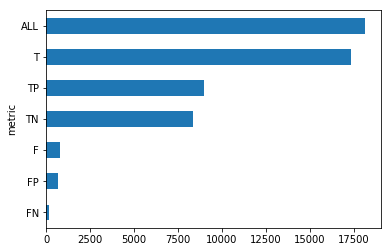

In [49]:
T1.T.sort_values('score').plot.barh(legend=False)

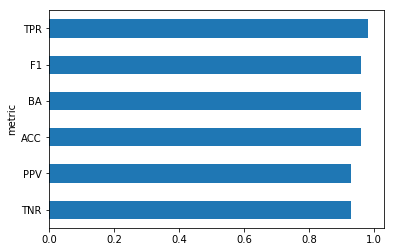

In [50]:
T2.T.sort_values('score').plot.barh(legend=False)

## CMs as probs

In [52]:
CM / CM.sum()

doc_label,A,B
prediction,,
A,0.984035,0.073984
B,0.015965,0.926016


In [152]:
CM / CM.sum(1)

doc_label,A,B
prediction,,
A,0.931092,0.078519
B,0.015106,0.982787


## Performance Metrics as Probabilities

![](../../lessons/conf_mat.png)

In [153]:
CM

doc_label,A,B
prediction,,
A,8999,666
B,146,8336


$P = 1$  
$N = 0$  
$\pi: predicted \in \{0,1\}$  
$\alpha: actual \in \{0,1\}$  
$T: p(\alpha = \pi) = T_0 + T_1$  
$F: p(\alpha \not= \pi) = F_0 + F_1$    
$TP = T_1 = p(\alpha=1, \pi=1)$    
$TN = T_0 = p(\alpha=0, \pi=0)$  
$FP = F_1 = p(\alpha=0, \pi=1)$  
$FN = F_0 = p(\alpha=1, \pi=0)$  

### Sensitivity or Recall:  
$TPR = R(T_1) = p(\pi=1|\alpha=1)$  

TPR is called sensitivity or recall depending on what it is contrasted with.
- Sensitivty vs. Specificity --> flip values
- Recall vs. Precision --> flip order 

### Specificty:  
$TNR = R(T_0) = p(\pi=0|\alpha=0)$  

### Precision:  
$PPV = p(\alpha=1|\pi=1)$

### Accuracy:  
$ACC = \dfrac{T}{T + F} = \dfrac{p(\alpha = \pi)}{p(\alpha=\pi) + p(\alpha\not=\pi)}$

### Balanced Accuracy:  
$BA = \dfrac{R(T_0)+R(T_1)}{2} = \dfrac{p(\pi=0|\alpha=0) + p(\pi=1|\alpha=1)}{2}$

### F1:  
$F1 = \dfrac{2T_1}{2T_0 + F} = \dfrac{2T_1}{2T_0 + F_1 + F_0}$

## Compute MI 

In [82]:
term_priors = tokens.loc[tokens.training==1].groupby('term_id').n.count().to_frame()
term_priors = term_priors / term_priors.sum()

In [83]:
term_priors.head()

,n
term_id,
379,0.000014
382,0.000007
385,0.000014
386,0.000007
392,0.000054


In [154]:
def estimate_mi(row):
    term_id = row.name
    pt = term_priors.loc[term_id]
    a = row.A * log(row.A / (class_priors.loc['A'] * pt))
    b = row.B * log(row.B / (class_priors.loc['B'] * pt))
    return pd.Series((a[0],b[0]))
MI = class_likelihoods.apply(estimate_mi, 1)

In [155]:
MI.columns = ['A','B']

In [156]:
MI['term_str'] = vocab.term_str

In [157]:
MI.sort_values('A', ascending=False).head(10)

,A,B,term_str
term_id,,,
17420,0.018227,0.026898,wine
4988,0.014631,0.002692,drink
1830,0.013643,-0.000086,black
15532,0.012875,0.002783,tannins
13003,0.011337,-0.001262,rich
13055,0.010657,0.001618,ripe
488,0.009513,0.011093,acidity
6590,0.008939,0.019908,fruit
11107,0.008819,0.015354,palate


In [158]:
MI.sort_values('B', ascending=False).head(10)

,A,B,term_str
term_id,,,
6213,0.004056,0.051223,flavors
17420,0.018227,0.026898,wine
1107,0.003360,0.026459,aromas
6109,0.003339,0.025426,finish
6590,0.008939,0.019908,fruit
15369,0.000460,0.016032,sweet
11107,0.008819,0.015354,palate
14386,-0.000015,0.013987,soft
14128,-0.000205,0.013390,simple


In [135]:
MI.describe().T

,count,mean,std,min,25%,50%,75%,max
A,7167.0,0.000163,0.000662,-0.000473,8.015129e-06,0.000025,0.000080,0.018227
B,7167.0,0.000188,0.001128,-0.001262,-9.363868e-07,0.000008,0.000085,0.051223


In [147]:
VA = MI[MI.A > 0.000080].sort_values('A', ascending=False)['term_str'].head(1000)

In [148]:
VB = MI[MI.B > 0.000085].sort_values('B', ascending=False)['term_str'].head(1000)

In [151]:
VA

term_id
17420            wine
4988            drink
1830            black
15532         tannins
13003            rich
13055            ripe
488           acidity
6590            fruit
11107          palate
17574           years
4294             dark
3049           cherry
14587           spice
6623             full
9146             long
3620     concentrated
17017        vineyard
6134             firm
621               age
17289            well
3566          complex
6599           fruits
15018      structured
15017       structure
4491            dense
15753         texture
6097             fine
7134            great
4443        delicious
14870           still
             ...     
14331        smoothly
12114        produces
16292          turned
16724            upon
5521          equally
2973       chardonnay
5031          dryness
14085       signature
13073         riserva
3787         contrast
3579       components
5995            feral
976          apparent
1907            blood
10